In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl



import sys
sys.path.append('../../')
from Subroutines import spectral_radius


In [2]:
plt.rcParams.update({'font.size': 15})

# Load Data

In [3]:
data_file_names = ['Plain',
                   'UnconstrainedDAP','ConstrainedDAP',\
                   'UnconstrainedLearning_eta_0.1','SafeLearning_eta_0.1',\
                   'Parameters'
                  ]

In [4]:
data = {}
for name in data_file_names:
    with open('./data/{}.pkl'.format(name),'rb') as f:
        data[name] = pkl.load(f)

In [5]:
AK = data['Parameters']['AK']
H_benchmark = data['Parameters']['H_benchmark']

In [6]:
spectral_radius(AK)**10

0.012558674125514422

In [7]:
data['Parameters']

{'Q': array([[1, 0],
        [0, 1]]),
 'R': array([[1.]]),
 'D_x': array([[ 1.,  0.],
        [ 0.,  1.],
        [-1., -0.],
        [-0., -1.]]),
 'd_x': array([5., 2., 1., 2.]),
 'D_u': array([[ 1.],
        [-1.]]),
 'd_u': array([5. , 9.8]),
 'w_cov': array([[0.04, 0.  ],
        [0.  , 0.04]]),
 'alpha_limit': (0.5, 1.2),
 'beta_limit': (0.2, 0.4),
 'H': 6,
 'H_benchmark': 6,
 'eta_bars': [0.1, 0.2, 0.5, 1.0],
 'A': array([[1.  , 1.  ],
        [0.  , 0.75]]),
 'AK': array([[ 1.        ,  1.        ],
        [-0.66666667, -0.25      ]]),
 'B': array([[0.],
        [1.]]),
 'A_hat_0': array([[1. , 1. ],
        [0. , 0.6]]),
 'B_hat_0': array([[0. ],
        [0.5]]),
 'r_0': 0.2,
 'w_max': 0.2,
 'K_stab': array([[0.66666667, 1.        ]]),
 'b_target': 0,
 'l': 0.25,
 'm': 1,
 'dt': 1}

# Plotting

## The plotting handler

In [8]:
def plot_with_errorband(ax,trial_data,label=''):
    mu = np.mean(trial_data,axis=0)
    std = np.std(trial_data,axis=0)

    indices = range(len(mu))

    ax.plot(np.array(mu),label=label)
    ax.fill_between(indices,mu+std,mu-std,alpha=0.2)

In [9]:
def plot_with_maxmin(ax,trial_data,label=''):
    max_x = np.max(trial_data,axis=0)
    min_x = np.min(trial_data,axis=0)
    median_x = np.median(trial_data,axis=0)

    indices = range(len(max_x))

    ax.plot(indices,median_x,label=label)
    
    ax.fill_between(indices,max_x,min_x,alpha=0.2)

## Calculate $x_{target}$

In [10]:
def get_x_target(data):
    AK = data['Parameters']['AK']
    B = data['Parameters']['B']
    b_target = data['Parameters']['b_target']


    return np.linalg.inv(AK-np.eye(AK.shape[0])).dot(B).dot(b_target)

## x,v,u vs time

## A figure showing unconstraint LQR violates actual constraints, either in x or in u.

In [11]:
x_max = data['Parameters']['d_x'][0]
x_min = -data['Parameters']['d_x'][2]

v_max = data['Parameters']['d_x'][1]
v_min = -data['Parameters']['d_x'][3]

u_max = data['Parameters']['d_u'][0]
u_min = -data['Parameters']['d_u'][1]

b = data['Parameters']['b_target']

In [12]:
x_target = get_x_target(data)

In [13]:
x_target

array([[0.],
       [0.]])

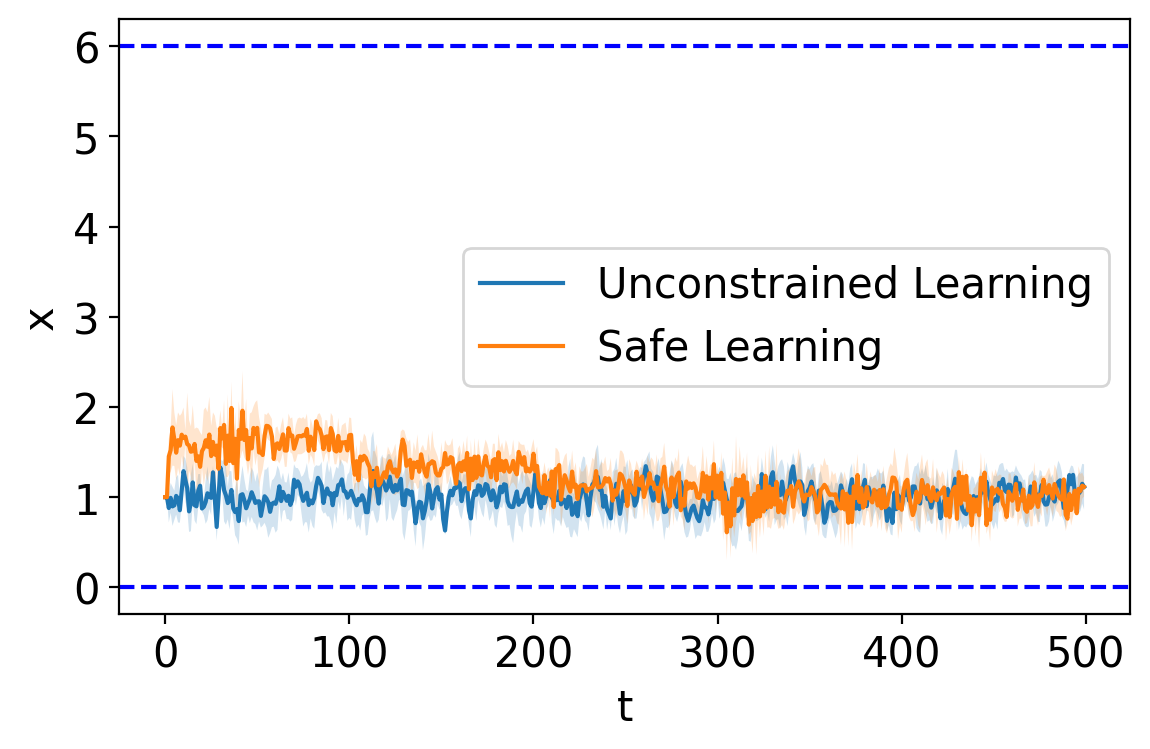

In [18]:
alg_names =  {
#                 'Plain':'Plain',\
#               'UnconstrainedDAP',\
#               'ConstrainedDAP',\
    'UnconstrainedLearning_eta_0.1':'Unconstrained Learning',
    'SafeLearning_eta_0.1':"Safe Learning"\
}



colors =  ['black','blue','red','green','orange']

color_map = {alg:c for (alg,c) in zip(alg_names,colors)}


plt.figure(dpi=200)

ax = plt.gca()
for key,name in alg_names.items():
    
    x_hist = np.array([d['x'] for d in data[key]])[:,:,0,0]
    
    
    hits = np.argwhere((x_hist[0]>x_max).flatten())
    
    if len(hits)>0:
        first_hit = np.min(hits)
        x_hist = x_hist[:,:first_hit+1]
    else:
        x_hist = x_hist[:,:]
    
    plot_with_errorband(ax,x_hist+1,label = name)


ax.axhline(x_max+1,ls='dashed',c='blue')
ax.axhline(x_min+1,ls='dashed',c='blue')
# ax.axhline(x_target[0,0],ls='solid',c='k')
# ax.set_title(name)

ax.set_xlabel('t')
ax.set_ylabel('x')

ax.legend(
#     bbox_to_anchor = [0.3, 0.1]
)


plt.tight_layout()
#     plt.show()
plt.savefig('./figures/x.png')


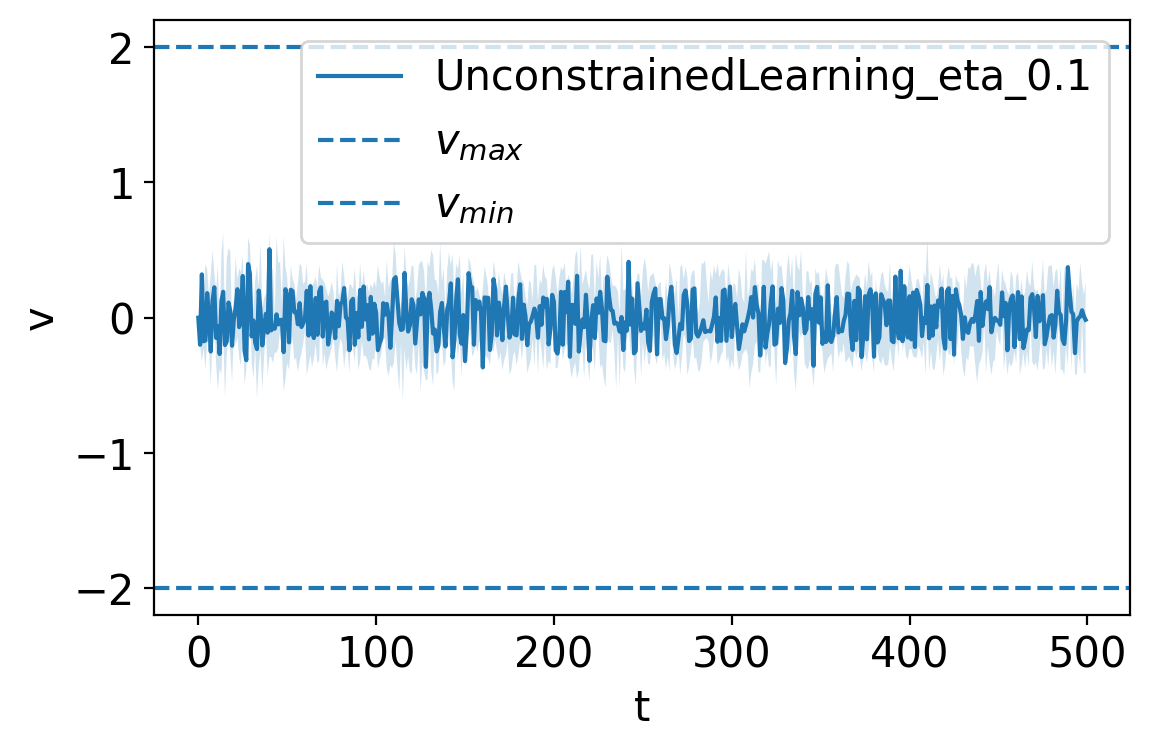

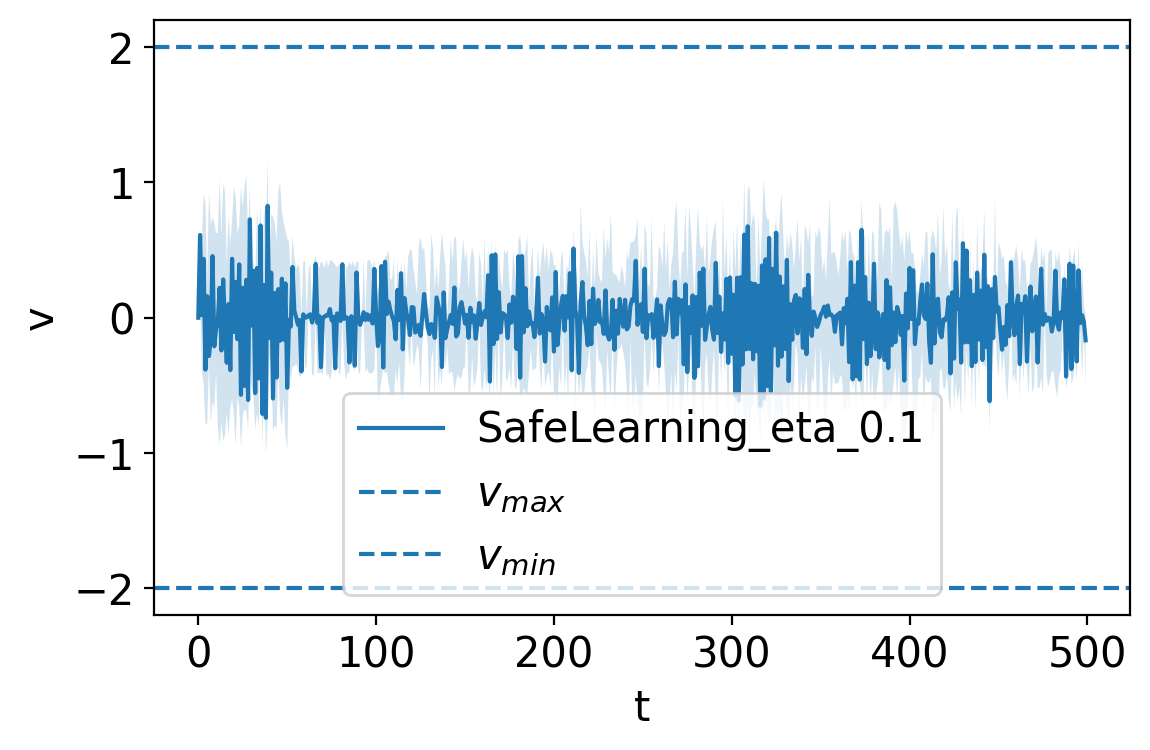

In [19]:

for name in alg_names:

    plt.figure(dpi=200)
    ax = plt.gca()    
   
    v_hist = np.array([d['x'] for d in data[name]])[:,:,1,0]     
    plot_with_maxmin(ax,v_hist,label = name)

    ax.axhline(v_max,label=r'$v_{max}$',ls='dashed')
    ax.axhline(v_min,label=r'$v_{min}$',ls='dashed')

    ax.set_xlabel('t')
    ax.set_ylabel('v')
    ax.legend()


    plt.tight_layout()
plt.savefig('./figures/v.png')


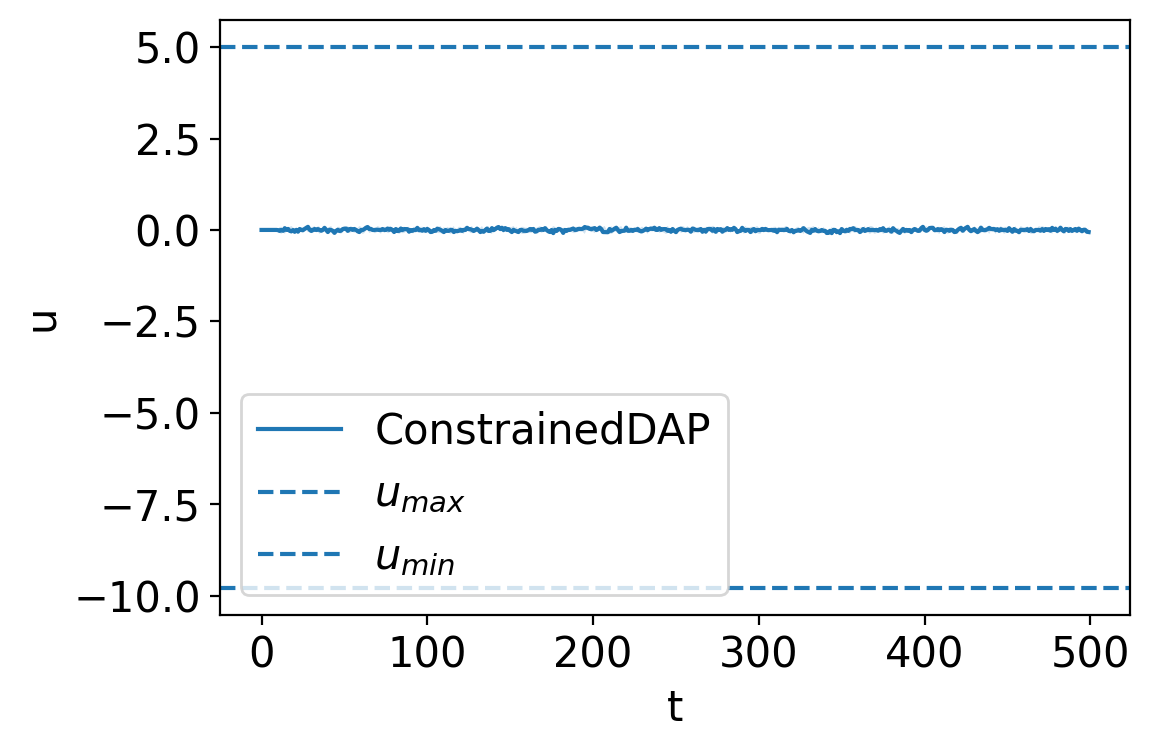

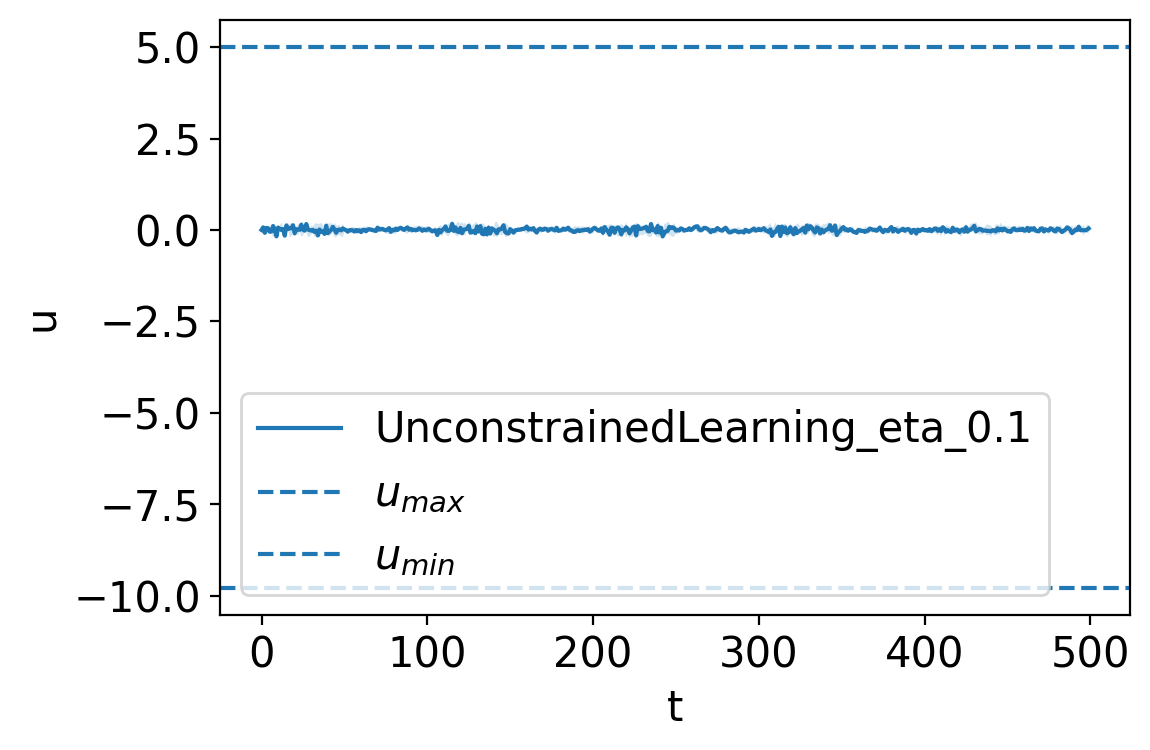

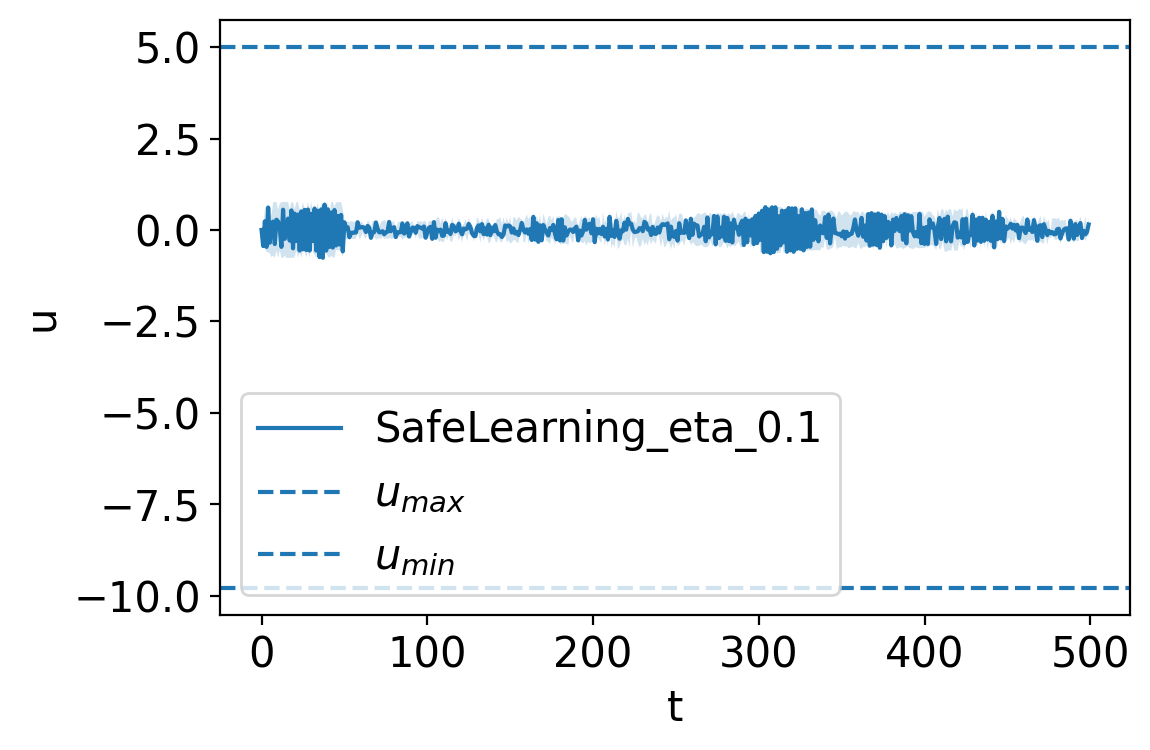

In [20]:
# control_alg = ['SafeLearning','UnconstrainedLearning']
control_alg = [
#                 'UnconstrainedDAP',
    'ConstrainedDAP',\
               'UnconstrainedLearning_eta_0.1','SafeLearning_eta_0.1'\
              ]

for name in control_alg:
    
    plt.figure(dpi=200)
    ax = plt.gca()
    v_hist = np.array([d['u'] for d in data[name]])  
    plot_with_maxmin(ax,v_hist,label = name)



    ax.axhline(u_max,label=r'$u_{max}$',ls='dashed')
    ax.axhline(u_min,label=r'$u_{min}$',ls='dashed')


    ax.set_xlabel('t')
    ax.set_ylabel('u')
    ax.legend()

    plt.tight_layout()
plt.savefig('./figures/u.png')
